# Semblance analysis and NMO correction for Volve dataset

#### original Author: Danilo Chamorro Riascos | danilo.riascos@kaust.edu.sa | ID 187518
#### modified by Xiao Ma | xiao.ma@kaust.edu.sa | ID 193561

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import scipy as sp
import scipy.signal as filt
import tqdm
import pickle

## File load

In [7]:
# Obtain this data from the following Zenodo link: https://zenodo.org/record/6572286#.Y8aDbC8Rr6-)
# data_file = np.load('/home/max0b/Seismology/ReflectionSeismic/VolveSynthetic_ZenodoData/Processing/input_mdd_volvesynth.npz')
# seismic_volume = data_file['Rinv']
# time = np.arange(2000) * 0.002
# receivers = np.arange(180) * 25

# seismic_volume.shape

(1500, 180, 180)

In [41]:
##for my data
data_file = np.load('mdd_volve_for_xiao.npz')
time = np.arange(2000) * 0.002
receivers = np.arange(180) * 25
seismic_volume = data_file["Rnsgd"]
#seismic_volume = data_file['Rinv']
print(data_file.files)
print(data_file["Rnsgd"].shape)
# print(data_file["r"])

['t', 'Rnsgd', 'r']
(2000, 180, 180)


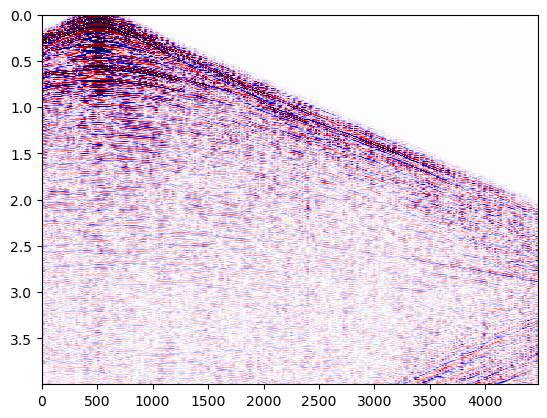

In [42]:
vm=np.percentile(data_file["Rnsgd"],99)
plt.imshow(data_file["Rnsgd"][:,20,:],vmin=-vm,vmax=vm,extent=(data_file["r"][0], data_file["r"][-1], data_file["t"][-1], data_file["t"][0]),aspect='auto',cmap="seismic")

In [35]:
# Obtain this velocity from the following Zenodo link: https://zenodo.org/record/6572286#.Y8aDbC8Rr6-)
# v_file = np.load('/home/max0b/Seismology/ReflectionSeismic/VolveSynthetic_ZenodoData/Velocity/Velocities.npz')
# velocity = v_file['vback']
# # time = np.arange(1500) * 0.002
# # receivers = np.arange(180) * 25
# print(v_file.files)
# # seismic_volume.shape

['vback', 'v', 'vnosea', 'x', 'z', 'xl', 'srcs', 'recs']


In [ ]:

# plt.imshow(velocity,cmap="jet",aspect="auto")

## Functions import

The following functions will be defined. The semblance and nmocorrection are implemented from the course notebook on the NMO method. The seismic_slice function is intended to ease the CMP-gather creation and handling.

In [43]:
def semblance(d, x, t, t0, vrms, nsmooth=5):
    """Semblance Stack

    Parameters
    ----------
    d : np.ndarray
        Data (nt x nx)
    x : np.ndarray
        Spatial axis
    t : np.ndarray
        Time axis
    t0 : np.ndarray
        Zero-offset time axis
    vrms : np.ndarray
        Root-mean-square velocity axis
    nsmooth : int, optional
        Length of smoothing filter

    Returns
    -------
    ss : np.ndarray
        Semblance stack (nt0 x nvrms)

    """
    # identify sampling and dimensions
    dt = t[1]-t[0]  # time lenght
    nx = x.size  # number of samples
    nt = t.size  # number of time measurements
    nvrms = vrms.size  # number of velocity estimates in the velocity spectra
    nt0 = t0.size  # number of time-zero measurements in the velocity spectra

    # compute semblance
    ix = np.arange(nx)  # offset axis
    num = np.zeros((nt0, nvrms))  # numerator in semblance formula
    den = np.zeros((nt0, nvrms))  # denominator in semblance formula
    nn = np.zeros((nt0, nvrms))  # length in semblance formula

    num_ab = np.zeros((nt0, nvrms))  # numerator in AB semblance formula
    den_ab = np.zeros((nt0, nvrms))  # denominator in AB semblance formula

    for it0, t0_ in enumerate(t0):
        # iterates over the vrms-t0 spectra
        for ivrms, vrms_ in enumerate(vrms):
            tevent = np.sqrt(t0_ ** 2 + x ** 2 / vrms_ **
                             2)  # traveltime of the event
            # normalizes the hyperbola and places it on the origin
            tevent = (tevent - t[0]) / dt
            itevent = tevent.astype(int)
            dtevent = tevent - itevent
            mask = (itevent < nt - 1) & (itevent >= 0)
            dss = d[itevent[mask], ix[mask]] * \
                (1 - dtevent[mask]) + \
                d[itevent[mask], ix[mask]] * dtevent[mask]
            xss = x[mask]

            # AB semblance
            num_ab[it0, ivrms] = (2 * np.sum(dss) * np.sum(xss) * np.sum(dss * xss)) - \
            (np.sum(dss)**2 * np.sum(xss**2)) - (len(dss) * np.sum(dss*xss)**2)
            den_ab[it0, ivrms] = np.sum(
                dss**2) * (np.sum(xss)**2 - len(dss) * np.sum(xss**2))

            # Ordinary semblance
            num[it0, ivrms] = np.sum(dss)**2
            den[it0, ivrms] = np.sum(dss**2)
            nn[it0, ivrms] = len(dss)

    ss = num / (nn * den + 1e-10)
    ss_ab = num_ab / (den_ab + 1e-10)

    # smooth along time axis
    ss = filt.filtfilt(np.ones(nsmooth) / nsmooth, 1, ss.T).T
    ss_ab = filt.filtfilt(np.ones(nsmooth) / nsmooth, 1, ss_ab.T).T

    return ss, ss_ab


def nmocorrection(d, x, t0, vrms, vmask=None):
    """Semblance Stack

    Parameters
    ----------
    d : np.ndarray
        Data (nt x nx)
    x : np.ndarray
        Spatial axis 
    t0 : np.ndarray
        Zero-offset time axis
    vrms : np.ndarray
        Root-mean-square velocity axis
    vmask : int, optional
        Velocity of linear event used as mask

    Returns
    -------
    dnmo : np.ndarray
        NMO corrected data stack (nt x nx)

    """
    # identify sampling and dimensions
    dt = t0[1]-t0[0]
    nx = x.size
    nvrms = vrms.size
    nt0 = t0.size

    # flatten events
    ix = np.arange(nx)
    dnmo = np.zeros((nt0, nx))
    for it0, t0_ in enumerate(t0):
        tevent = np.sqrt(t0_ ** 2 + x ** 2 / vrms[it0] ** 2)
        tevent = (tevent - t0[0]) / dt
        itevent = tevent.astype(int)
        dtevent = tevent - itevent
        mask = (itevent < nt0 - 1) & (itevent >= 0)
        nmask = np.sum(mask)
        dnmo[it0 * np.ones(nmask, dtype='int'), ix[mask]] += \
            d[itevent[mask], ix[mask]] * \
            (1 - dtevent[mask]) + d[itevent[mask], ix[mask]] * dtevent[mask]

    # apply mask
    mask = np.ones((nt0, nx))
    if vmask:
        tmask = x / vmask
        itmask = (tmask / dt).astype(int)
        for ix in range(nx):
            mask[:itmask[ix], ix] = 0.
        dnmo *= mask
    fold = np.sum(mask, axis=1)
    return dnmo, fold


def slice(receivers=receivers, seismic_volume=seismic_volume, receiver_position=180):
    """Slices the seismic volume according to the receiver_position parameter

    Args:
        receivers (_type_, optional): List of receivers positions. Defaults to receivers.
        seismic_volume (_type_, optional): Array of 3 axis with (t, s, r). Defaults to seismic_volume.
        receiver_position (int, optional): Distance from 0 to compute the receiver_position. Defaults to 180.

    Returns:
        offsets: Offsets axis for posterior analysis
        sliced_volume: 2D array for the requested receiver_position
    """

    if receiver_position > 0:
        sources_axs = [s for s in range(receiver_position//2, 0, -1)]
        receivers_axs = [r for r in range(receiver_position//2, receiver_position - receiver_position % 2, 1)]

    elif receiver_position < 0:
        receiver_position = 180+receiver_position
        sources_axs = [s for s in range(
            receiver_position + (180-receiver_position)//2, receiver_position - receiver_position % 2, -1)]
        receivers_axs = [r for r in range(
            receiver_position + (180-receiver_position)//2, 180, 1)]

    offsets = receivers[receivers_axs] - receivers[sources_axs]
    #print(sources_axs,receivers_axs)
    sliced_volume = seismic_volume[:, sources_axs, receivers_axs]

    return offsets, sliced_volume


def maxpicker(spectra, t0axis, vrmsaxis):
    """Picks the maximum over the semblance spectra 

    Args:
        spectra (np.ndarray): Semblance spectra
        t0axis (np.ndarray): t0 axis 
        vrmsaxis (np.ndarray): vrms axis

    Returns:
        t0maxs: Array of values along the t0 axis where the maximum has been picked
        vrmsaxis[maxs_t]: Array of values along the vrms axis where the maximum has been picked 
    """
    _maxs_t = np.zeros(spectra.shape[0], dtype=np.int8)
    values = np.zeros(spectra.shape[0])

    tol = 0.38  # Initial tolerance for maximum

    # If under the current tolerance it doesn't pick anything, keep iterating until we have at least 10 pickings
    while len(values[np.where(values != 0)]) < 10:

        for i in range(0, spectra.shape[0], 10):
            loc = int(np.argmax(spectra[i, :]))
            val = spectra[i, loc]
            if val > tol and vrmsaxis[loc] > 1650:
                _maxs_t[i] = loc
                values[i] = val

        tol = tol - 0.1  # Decrease the tolerance if not enough pickings

    maxs_t = np.delete(_maxs_t, np.where(_maxs_t == 0))
    t0maxs = np.delete(t0axis, np.where(_maxs_t == 0))

    return t0maxs, vrmsaxis[maxs_t]

### Slice example

I will demonstrate the workflow implemented on a single slice first before running it for a bigger portion of the dataset. It's important to explain the notation that will be employed by the *slice* function in order to select the proper shot-gathers. The main parameter that the function takes is the one defined as slice. This value will select the CMP gather whose source is 0 (when slice is positive) or 180 (when slice is negative) and the number of the receiver is the one defined by the slice parameter. In the following plot we can see that for an x=180 we will select the longest shot-gather available, but as we pick a lower value we will select seismic lines on the upper triangular portion (shown as green). If on the other hand we want to pick the lines at the opposite side, we use a negative sign for the slice parameter and with the same thinking in mind we will be picking a line whose source is the 180th and the receiver is at the 180-X position. This function will return the offsets and the CMP shot gather for the selected positions.

<p align="center">
<img src="map.png" width="400">

In [44]:
offs, cmp = slice(receiver_position=50) 

In [45]:
cmp.shape

(2000, 25)

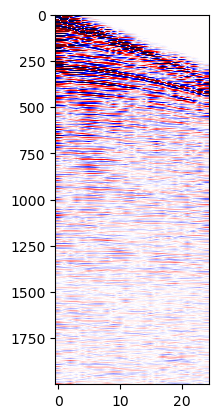

In [46]:
#plt.imshow(cmp,aspect="auto")
plt.imshow(cmp,vmin=-vm,vmax=vm,aspect='0.03',cmap="seismic",interpolation="bilinear")

After loading the desired shot-gather we can run the semblance function to return the classical semblance as the first argument, and the AB semblance as the second one

In [47]:
t0axis = time.copy()
vrmsaxis = np.linspace(2000, 2800, 120)
ss, ss_ab = semblance(cmp, offs, time, t0axis, vrmsaxis, nsmooth=5)

The maximum is picked using the function defined as **maxpicker**, where it runs over the rows (time axis) of the semblance array looking for values higher than 0.38 (this threshold was defined with several observations and given that the semblance is a value between 0 and 1 we can choose the same for all of the results). If after the first run there are not enough values (at least 10), the threshold decreases by 0.1. 

In [48]:
tmax, vrmsmax = maxpicker(ss_ab, t0axis, vrmsaxis)
vrmsnmo = np.interp(t0axis, tmax, vrmsmax)

tmax_c, vrmsmax_c = maxpicker(ss, t0axis, vrmsaxis)
vrmsnmo_c = np.interp(t0axis, tmax_c, vrmsmax_c)

In [49]:
# Axis and function to plot the picked hyperbolas over the shot-gather

_offaxis = np.linspace(0, offs[-1], 100)
_hyperb = lambda t0, vel, x: np.sqrt(t0**2 + x**2/vel**2)

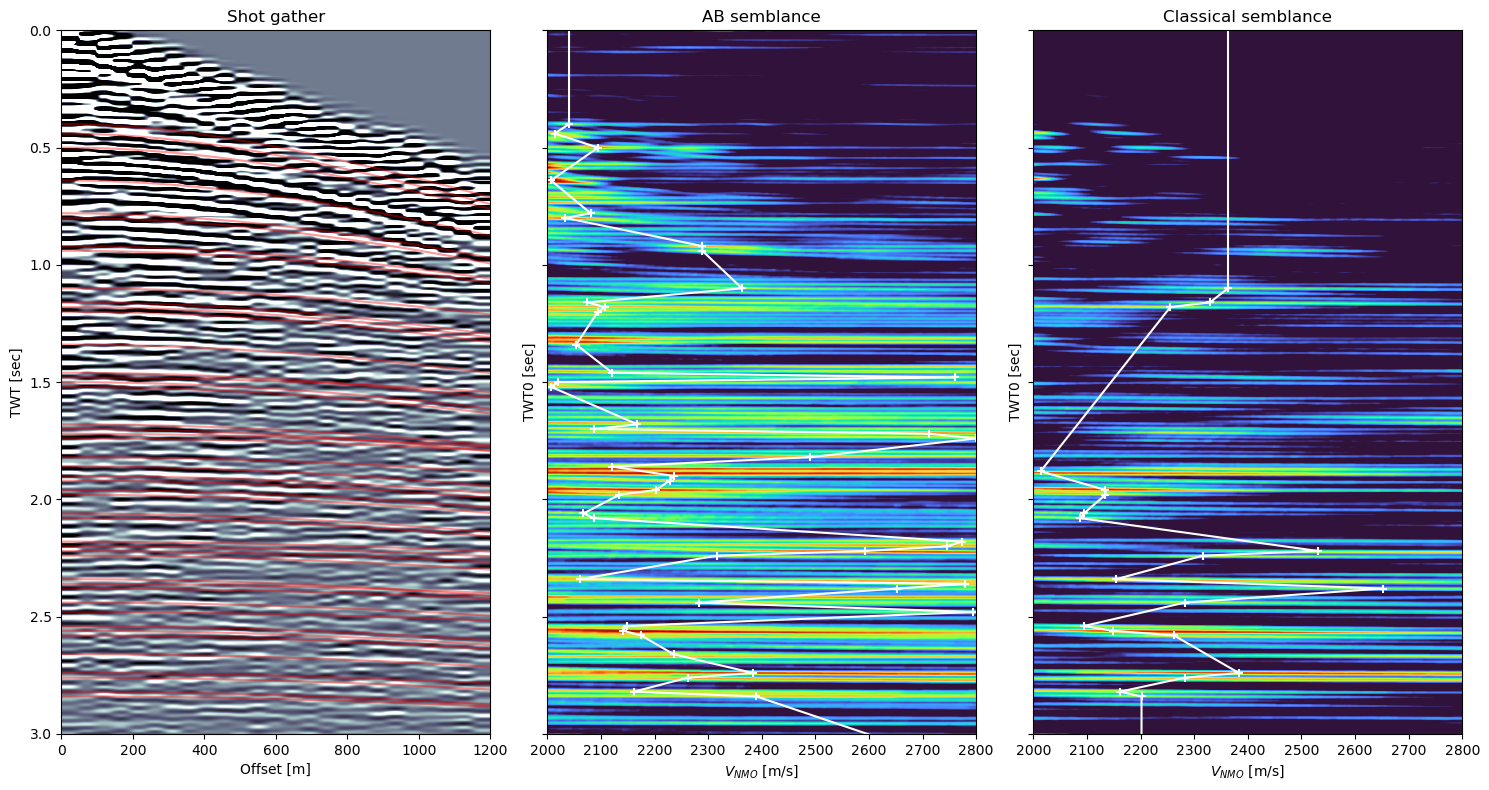

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8), sharey=True)

axs[0].imshow(cmp, cmap='bone', norm=colors.TwoSlopeNorm(vmin=np.min(cmp)/30, vcenter=0, vmax=np.max(cmp)/30), extent=(offs[0], offs[-1], time[-1], time[0]), aspect='auto')

for i in range(len(tmax)):
    axs[0].plot(_offaxis, _hyperb(tmax[i], vrmsmax[i], _offaxis), c='red', alpha=0.4)
axs[0].set(ylim=(3, 0), title='Shot gather', xlabel='Offset [m]', ylabel='TWT [sec]')


axs[1].imshow(ss_ab, cmap='turbo', vmin=0.1, vmax=0.7, extent=(vrmsaxis[0], vrmsaxis[-1], t0axis[-1], t0axis[0]), aspect='auto')
axs[1].scatter(vrmsmax, tmax, marker='+', c='white')
axs[1].plot(vrmsnmo, t0axis, 'white')
axs[1].set(title='AB semblance',  xlabel='$V_{NMO}$ [m/s]', ylabel='TWT0 [sec]')

axs[2].imshow(ss, cmap='turbo', vmin=0.1, vmax=0.7, extent=(vrmsaxis[0], vrmsaxis[-1], t0axis[-1], t0axis[0]), aspect='auto')
axs[2].scatter(vrmsmax_c, tmax_c, marker='+', c='white')
axs[2].plot(vrmsnmo_c, t0axis, 'white')
axs[2].set(title='Classical semblance', xlabel='$V_{NMO}$ [m/s]', ylabel='TWT0 [sec]')

plt.tight_layout()

After obtaining our semblance results we can correct using the function provided by the professor. 

In [51]:
dnmo, fold = nmocorrection(cmp, offs, t0axis, vrmsnmo, vmask=1500)
dstack = np.sum(dnmo, axis=-1) / fold

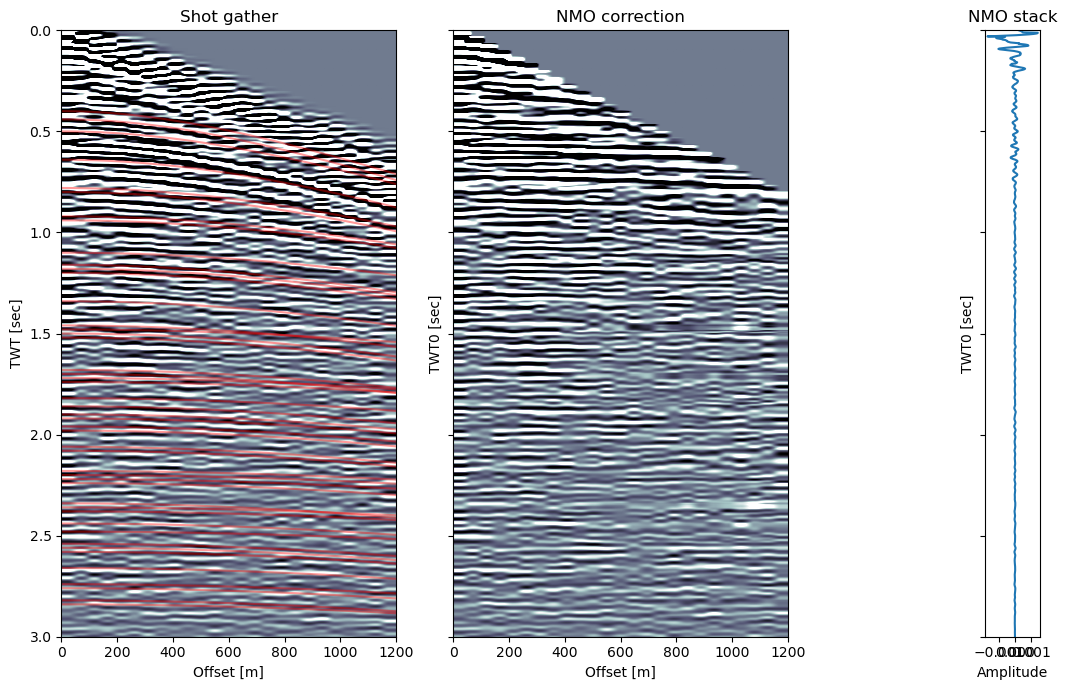

In [52]:
scale = 30
fig, axs = plt.subplots(1, 3, figsize=(12,7), sharey=True)

axs[0].imshow(cmp, cmap='bone', norm=colors.TwoSlopeNorm(vmin=np.min(dnmo)/scale, vcenter=0, vmax=np.max(dnmo)/scale), extent=(offs[0], offs[-1], time[-1], time[0]), aspect='auto')
for i in range(len(tmax)):
    axs[0].plot(_offaxis, _hyperb(tmax[i], vrmsmax[i], _offaxis), c='red', alpha=0.4)
axs[0].set(ylim=(3, 0), title='Shot gather', xlabel='Offset [m]', ylabel='TWT [sec]');

axs[1].imshow(dnmo, cmap='bone', norm=colors.TwoSlopeNorm(vmin=np.min(dnmo)/scale, vcenter=0, vmax=np.max(dnmo)/scale), extent=(offs[0], offs[-1], time[-1], time[0]), aspect='auto')
axs[1].set(title='NMO correction', xlabel='Offset [m]', ylabel='TWT0 [sec]');

axs[2].plot(dstack, time)
axs[2].set(title='NMO stack', xlabel='Amplitude', ylabel='TWT0 [sec]', aspect=1/80);

plt.tight_layout()

## 2D section
In order to apply the previously defined workflow to define a $V_{RMS}$ model and ZO section, the following function is implemented to iterate over the defined sections

In [240]:
def workflow(position):

    offs, cmp = slice(receiver_position=position) 
    ss, ss_ab = semblance(cmp, offs, time, t0axis, vrmsaxis, nsmooth=5)

    tmax, vrmsmax = maxpicker(ss_ab, t0axis, vrmsaxis)
    vrmsnmo = np.interp(t0axis, tmax, vrmsmax)

    tmax_c, vrmsmax_c = maxpicker(ss, t0axis, vrmsaxis)
    vrmsnmo_c = np.interp(t0axis, tmax_c, vrmsmax_c)

    dnmo, fold = nmocorrection(cmp, offs, t0axis, vrmsnmo, vmask=1500)
    dstack = np.sum(dnmo, axis=-1) / fold

    return dstack, tmax, vrmsmax,tmax_c, vrmsmax_c 

Then we define the lists that will contain the information related to the 2D section. Given the aforementioned nomenclature to define the slices of the CMP gathers and how they are related depending if they are on the upper or lower triangular of the grid, the workflow was divided in two sections for each type of position and is later joined.

In [241]:
if True:
    dstack_section = []
    tmax_section = []
    vrmsmax_section = []
    tmax_c_section = []
    vrmsmax_c_section = []

    for position in tqdm.tqdm(range(90, 180)):

        dstack, tmax, vrmsmax,tmax_c, vrmsmax_c = workflow(position)

        dstack_section.append(dstack)
        tmax_section.append(tmax)
        vrmsmax_section.append(vrmsmax)
        tmax_c_section.append(tmax_c)
        vrmsmax_c_section.append(vrmsmax_c)

100%|██████████| 90/90 [21:33<00:00, 14.38s/it]


In [224]:
# 打开一个文件以保存对象
with open("data.pkl", "wb") as file:
    pickle.dump((dstack_section,tmax_section,vrmsmax_section,tmax_c_section,vrmsmax_c_section), file)

As for the CMP gathers that are on the lower side of the main counter diagonal we have: 

In [242]:
if True:
    dstack_section_opposite = []
    tmax_section_opposite = []
    vrmsmax_section_opposite = []
    tmax_c_section_opposite = []
    vrmsmax_c_section_opposite = []

    for position in tqdm.tqdm(range(-180, -90, 1)):

        dstack, tmax, vrmsmax,tmax_c, vrmsmax_c = workflow(position)

        dstack_section_opposite.append(dstack)
        tmax_section_opposite.append(tmax)
        vrmsmax_section_opposite.append(vrmsmax)
        tmax_c_section_opposite.append(tmax_c)
        vrmsmax_c_section_opposite.append(vrmsmax_c)

100%|██████████| 90/90 [21:28<00:00, 14.32s/it]


In [225]:
with open("data_lower.pkl", "wb") as file:
    pickle.dump((dstack_section_opposite,tmax_section_opposite,vrmsmax_section_opposite,tmax_c_section_opposite,vrmsmax_c_section_opposite), file)

In [237]:
len(vrmsmax_section_opposite)

100

Given the long computation times (it takes around 40 minutes to run the whole section), the results of the previous blocks of code are attached and can be loaded on demand.(named data.pkl and data_lower.pkl)

In [15]:
# with open('section_upper.pickle', 'rb') as handle:
#     dstack_section, \
#      tmax_section, \
#      vrmsmax_section, \
#      tmax_c_section, \
#      vrmsmax_c_section = pickle.load(handle)

# with open('section_lower.pickle', 'rb') as handle:
#     dstack_section_opposite, \
#      tmax_section_opposite, \
#      vrmsmax_section_opposite, \
#      tmax_c_section_opposite, \
#      vrmsmax_c_section_opposite = pickle.load(handle)

In [31]:
with open('data.pkl', 'rb') as handle:
    dstack_section1, \
     tmax_section1, \
     vrmsmax_section1, \
     tmax_c_section1, \
     vrmsmax_c_section1 = pickle.load(handle)

with open('data_lower.pkl', 'rb') as handle:
    dstack_section_opposite1, \
     tmax_section_opposite1, \
     vrmsmax_section_opposite1, \
     tmax_c_section_opposite1, \
     vrmsmax_c_section_opposite1 = pickle.load(handle)

In [32]:
section_pos = np.vstack(dstack_section1)
section_pos_opposite = np.vstack(dstack_section_opposite1)

section_zo = np.vstack((section_pos, section_pos_opposite)).T

Given the receiver distance along the x axis we can obtain the distance between mid array receivers using trigonometry so that this distance is $\Delta x / \sqrt{2}$

In [33]:
xmidaxis = np.arange(200)*25/np.sqrt(2)

Text(0, 0.5, 'TWT0 [sec]')

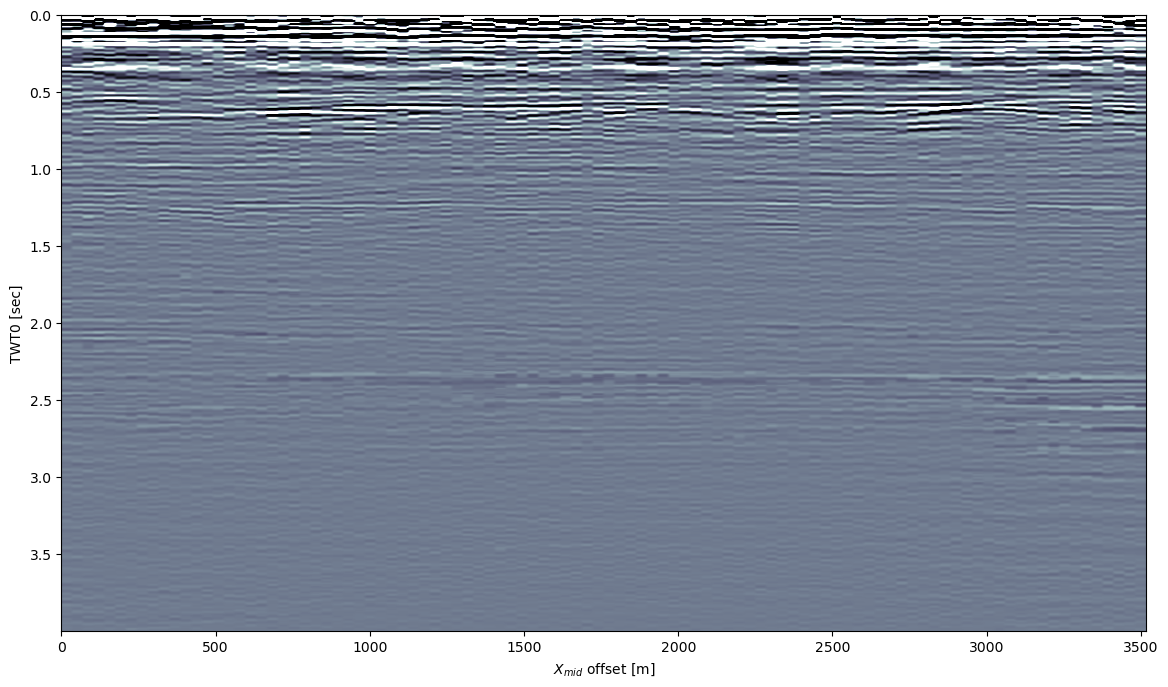

In [34]:
scale = 80
plt.figure(figsize=(14, 8))
plt.imshow(section_zo, aspect='auto', cmap='bone', norm=colors.TwoSlopeNorm(vmin=np.min(
    section_zo)/scale, vcenter=0, vmax=np.max(section_zo)/scale), extent=(xmidaxis[0], xmidaxis[-1], time[-1], time[0]))
plt.xlabel('$X_{mid}$ offset [m]')
plt.ylabel('TWT0 [sec]')

In [35]:
np.save("section_zo.npy",section_zo)

In [36]:
section_zo.shape

(2000, 200)

In [37]:
velmodel = np.zeros((2000, 90))
velmodel_opposite = np.zeros((2000, 90))

for i in range(90):
    velmodel[:, i] = np.interp(t0axis, tmax_section1[i], vrmsmax_section1[i])
    velmodel_opposite[:, i] = np.interp(t0axis, tmax_section_opposite1[i], vrmsmax_section_opposite1[i])

vrmsmodel = np.hstack((velmodel, velmodel_opposite))

As for the Vrms velocity model we obtained the following results:

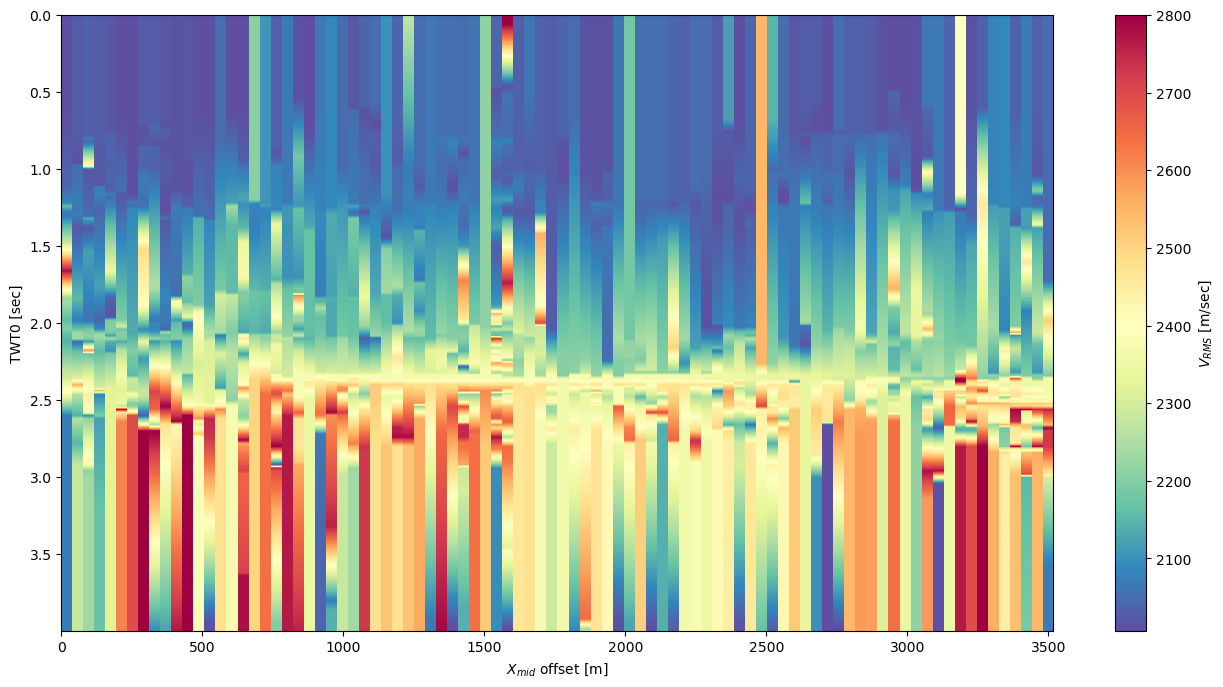

In [38]:
plt.figure(figsize=(16, 8))

plt.imshow(vrmsmodel, aspect='auto', cmap='Spectral_r', extent=(xmidaxis[0], xmidaxis[-1], time[-1], time[0]), interpolation='none')
plt.colorbar(label='$V_{RMS}$ [m/sec]')

plt.xlabel('$X_{mid}$ offset [m]');
plt.ylabel('TWT0 [sec]');

In [39]:
from scipy.ndimage import gaussian_filter
v_mig = np.array(1/gaussian_filter(1/vrmsmodel, 3))

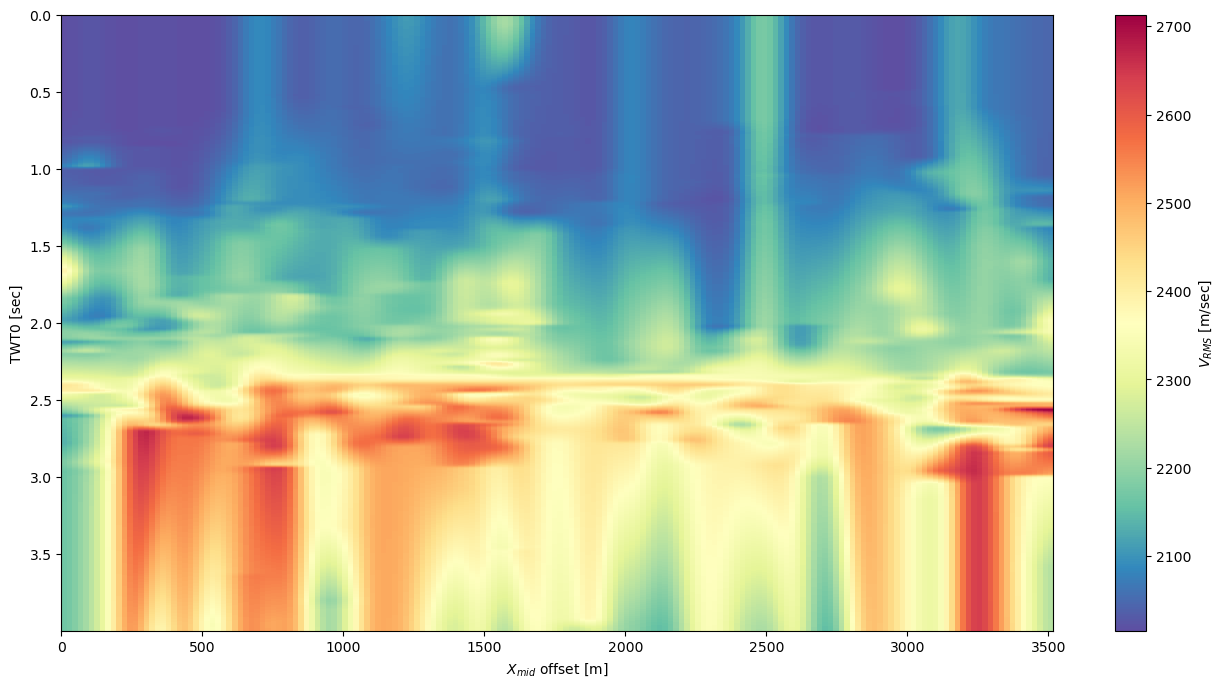

In [40]:
plt.figure(figsize=(16, 8))

plt.imshow(v_mig, aspect='auto', cmap='Spectral_r', extent=(xmidaxis[0], xmidaxis[-1], time[-1], time[0]), interpolation='none')
plt.colorbar(label='$V_{RMS}$ [m/sec]')

plt.xlabel('$X_{mid}$ offset [m]');
plt.ylabel('TWT0 [sec]');